Pull in the train and test sets created in preprocessing

In [60]:
import pandas as pd

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
bee_colony_data = pd.read_csv('bee_data_after_preprocessing.csv')

ARMA model (autoregression, moving average - not using differencing)

First, check if the data is stationary using the Augmented Dickey Fuller test (I assume it's not because it's seasonal).

In [61]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(bee_colony_data['Percent lost'].dropna())
print('Augmented Dickey Fuller statistic: %f' % result[0])
print('p-value: %f' % result[1])

Augmented Dickey Fuller statistic: -6.509814
p-value: 0.000000


Next, find out number of required AR terms by inspecting the autocorrelation plot (correlation between the series and its lag, after excluding the contributions from intermediate lags)

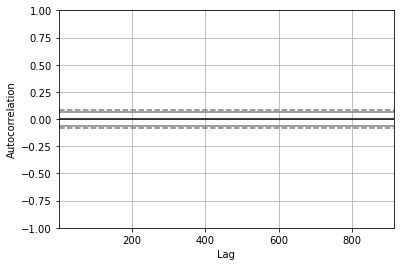

In [62]:
import matplotlib.pyplot as plt
import numpy as np

time_array = np.array(y_train['Percent lost'].values)
pd.plotting.autocorrelation_plot(time_array)
plt.show()

This seems to point to the AR parameter being 0. 

Since the first version I'm going to run is just ARMA (without the I for differencing), this points to the starting value for `p` and `d` being 0. 

Next up, I'll try fitting the ARMA model to the training data.

In [63]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, order=(0, 0, 0))
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Percent lost   No. Observations:                  913
Model:                          ARIMA   Log Likelihood               -1318.587
Date:                Fri, 11 Feb 2022   AIC                           2641.173
Time:                        10:07:57   BIC                           2650.807
Sample:                             0   HQIC                          2644.851
                                - 913                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.046     -0.046      0.963      -0.092       0.088
sigma2         1.0756      0.034     31.747      0.000       1.009       1.142
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1918.36
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             1.88
Prob(H) (two-sided):                  0.20   Kurtosis:                         9.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

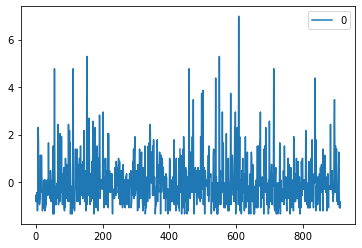

In [64]:
residuals = pd.DataFrame(fitted_model.resid)
residuals.plot()
plt.show()

Line plot of the residual errors

Next, a density plot of residuals and summary stats of residuals

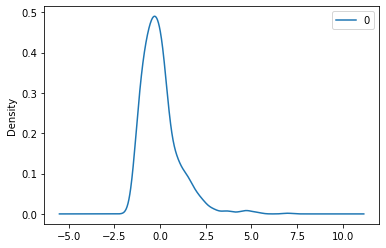

                0
count  906.000000
mean     0.000005
std      1.037701
min     -1.343502
25%     -0.693210
50%     -0.172976
75%      0.347258
max      6.980241


In [65]:
residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

The errors are Gaussian and appear to be centered on zero. A mean very close to 0 in the summary statistics points to no bias in the predictions.

Now, to add in a rolling forecast, generating a prediction for each element in the test set, using the model fit above.

In [83]:
from statsmodels.tsa.arima_model import ARMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = list()
history = [y for y in y_train]
y_test_as_list = y_test.values.tolist()

for t in range(len(y_test_as_list)):
    forecast = fitted_model.predict()
    yhat = forecast[0]
    predictions.append(yhat) 
    obs = y_test_as_list[t][0]
    history.append(obs)
    print("predicted=%f, expected=%f" % (yhat, obs))
    
rmse = sqrt(mean_squared_error(y_test, predictions))
print("Test RMSE: %.3f" % rmse)

predicted=-0.002142, expected=0.345117
predicted=-0.002142, expected=-0.305176
predicted=-0.002142, expected=-0.305176
predicted=-0.002142, expected=-0.435234
predicted=-0.002142, expected=-0.695351
predicted=-0.002142, expected=-0.825410
predicted=-0.002142, expected=-0.305176
predicted=-0.002142, expected=-0.305176
predicted=-0.002142, expected=0.345117
predicted=-0.002142, expected=0.085000
predicted=-0.002142, expected=-1.085527
predicted=-0.002142, expected=1.515643
predicted=-0.002142, expected=-0.435234
predicted=-0.002142, expected=2.035877
predicted=-0.002142, expected=0.605234
predicted=-0.002142, expected=-0.435234
predicted=-0.002142, expected=-0.695351
predicted=-0.002142, expected=0.215058
predicted=-0.002142, expected=-0.435234
predicted=-0.002142, expected=-0.175117
predicted=-0.002142, expected=-0.045059
predicted=-0.002142, expected=1.385584
predicted=-0.002142, expected=1.255526
predicted=-0.002142, expected=-1.345644
predicted=-0.002142, expected=-0.565293
predicted

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

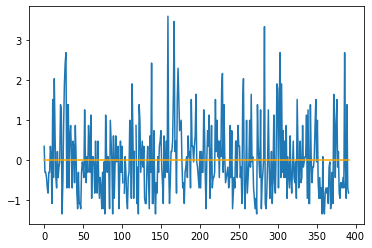

In [81]:
plt.plot(y_test_as_list)
plt.plot(predictions, color='orange')
plt.show()

ARIMA model - this data is seasonal, so I'm assuming that the ARIMA won't work. But I want to run it to see the differences between it and a SARIMA model and see how it would go wrong when fed seasonal data 

SARIMA model